In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import os

from pclib.nn.models import ConvAM
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import identity
from pclib.utils.customdataset import PreloadedDataset

In [2]:
seed = 42
# For reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

dataset = datasets.CIFAR10('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
dataset = torch.utils.data.Subset(dataset, range(100))
train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)

INPUT_SHAPE = 3072
MAX, MIN = train_dataset.transformed_images.max().item(), train_dataset.transformed_images.min().item()

def normalize(x):
    return (x - MIN) / (MAX - MIN)

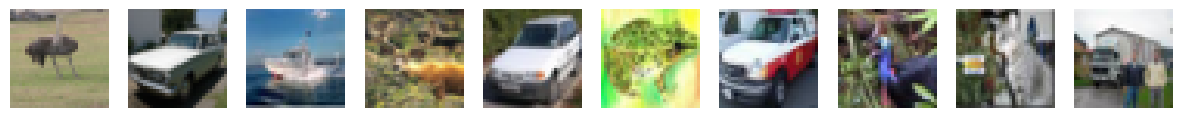

In [4]:
train_dataset.apply_transform()
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
idxs = torch.randperm(len(train_dataset))[:10]
for i, ax in enumerate(axes):
    img, label = train_dataset[idxs[i]]
    ax.imshow(normalize(img).permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
plt.show()

In [11]:
torch.manual_seed(seed)

model_name = 'ConvAM_256'
model = ConvAM(
    steps=100,
    bias=False, 
    symmetric=True,
    actv_fn=F.sigmoid,
    gamma=0.1,
    ).to(device)

In [12]:
# Train Loop
BATCH_SIZE = 100

log_dir = f'examples/cifar10_assoc_mem/out/logs/{model_name}'

NUM_EPOCHS = 10000
train(
    model, 
    train_dataset, 
    None, 
    NUM_EPOCHS, 
    lr=0.0001,
    c_lr=0.00,
    batch_size=BATCH_SIZE,
    reg_coeff=0.2,
    optim='SGD',
    log_dir=log_dir,
    no_momentum=True,
    minimal_stats=True,
    # scheduler='ReduceLROnPlateau',
    norm_grads = False,
    flatten=False,
)

In [35]:
def eval_accuracy(model, dataset):

    img = train_dataset.transformed_images
    noised = img + 0.2 * torch.randn_like(img)
    output, _ = model(noised)
    error = F.mse_loss(output, img, reduction='none').mean(dim=(1, 2, 3))
    print(f"error.shape: {error.shape}")
    total_error = error.sum().item()
    correct = error[error < 0.005].size(0)
    return correct / len(dataset), total_error / len(dataset)

eval_accuracy(model, train_dataset)

error.shape: torch.Size([100])


(0.1, 0.008618122935295104)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

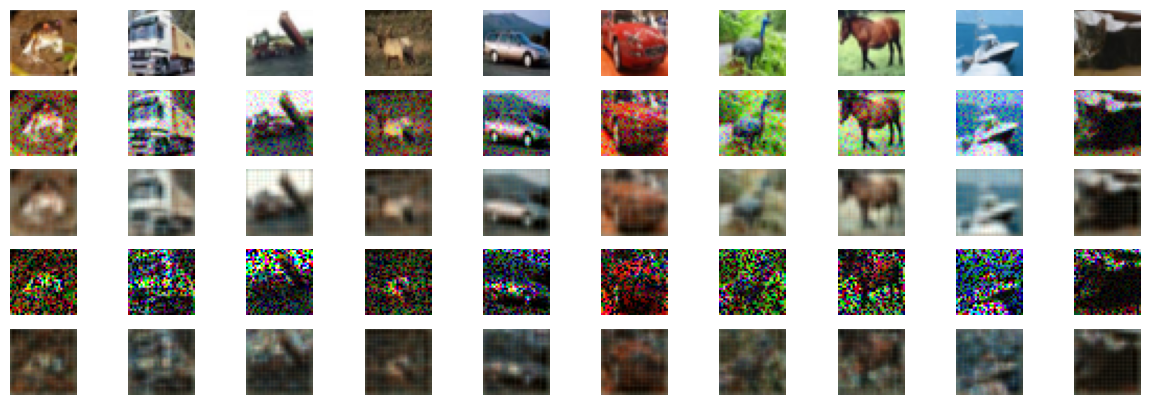

In [36]:
X = train_dataset.transformed_images
X_noisy = X + torch.randn_like(X) * 0.2
X_noisy = F.normalize(X_noisy, dim=1) * X.norm(dim=1, keepdim=True)
X_noisy_recon = model(X_noisy.to(device), steps=200)[0].cpu()
X_partial = X * (torch.rand_like(X) < 0.5).float()
X_partial_recon = model(X_partial.to(device), steps=200)[0].cpu()

# Show all 10 images, raw, noised and reconstructed
fig, axes = plt.subplots(5, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(normalize(X[i]).permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(normalize(X_noisy[i]).permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(normalize(X_noisy_recon[i]).permute(1, 2, 0).cpu().detach().numpy())
    ax.axis('off')
for i, ax in enumerate(axes[3]):
    ax.imshow(normalize(X_partial[i]).permute(1, 2, 0).cpu().numpy())
    ax.axis('off')
for i, ax in enumerate(axes[4]):
    ax.imshow(normalize(X_partial_recon[i]).permute(1, 2, 0).cpu().detach().numpy())
    ax.axis('off')


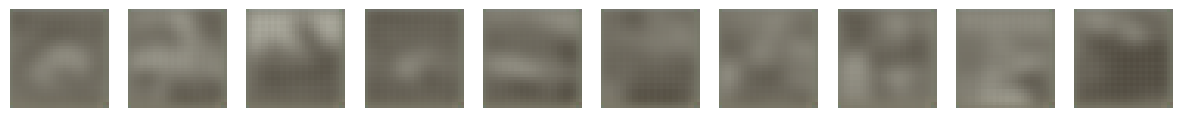

In [49]:
X_noisy_recon = model(X_noisy_recon.to(device), steps=200)[0].cpu()

# show noisy recon
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(normalize(X_noisy_recon[i]).permute(1, 2, 0).detach().cpu().numpy())
    ax.axis('off')
plt.show()

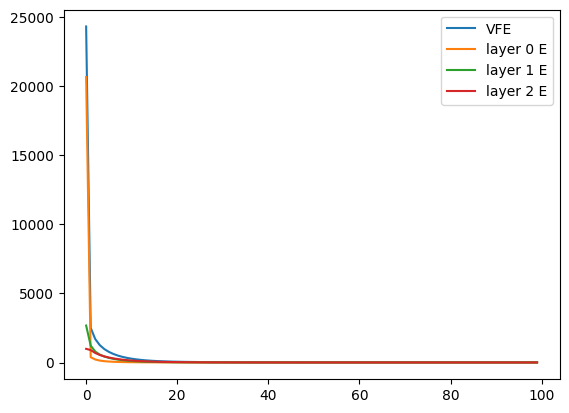

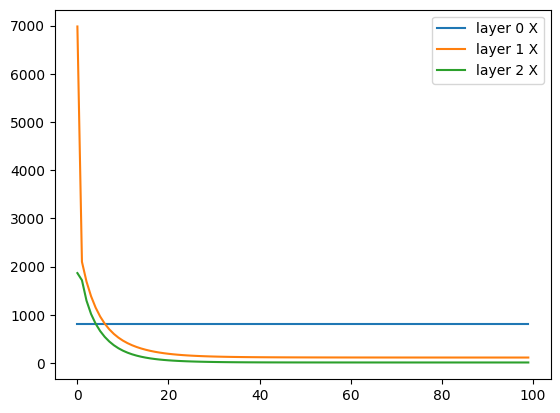

Layer 0 e_min, e_max, x_min, x_max: 803.131, 803.131, 7.312, 20635.551
Layer 1 e_min, e_max, x_min, x_max: 114.430, 6982.393, 5.836, 2672.265
Layer 2 e_min, e_max, x_min, x_max: 11.947, 1866.778, 2.869, 989.006


In [23]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, x=x, steps=100, plot_Es=True, plot_Xs=True)
for i in range(len(model.layers)):
    print(f'Layer {i} e_min, e_max, x_min, x_max: {min(E[i]):.3f}, {max(E[i]):.3f}, {min(X[i]):.3f}, {max(X[i]):.3f}')